In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from google.colab import drive

In [ ]:
# dataset, dataset_info = tfds.load(
#     "malaria", with_info=True, split=['train[:80%]','train[80%:90%]','train[90%:]'], shuffle_files=True
#     )
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, shuffle_files=True
    )

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [ ]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_ds, val_ds, test_ds = split(dataset["train"], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print( len(test_ds))

22046
2755
2757


In [ ]:
def get_label_str(label):
  return "Parasitized" if label == 0 else "Uninfected"

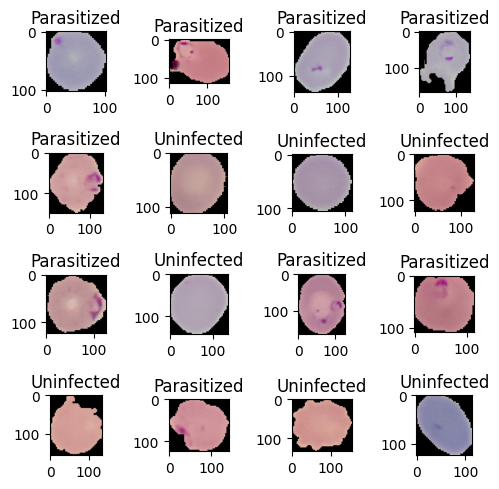

In [ ]:
fig = plt.figure(figsize=(5, 5))
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))
  plt.tight_layout()

In [2]:
IM_size = 224
BATCH_SIZE = 32

In [ ]:
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (IM_size, IM_size))/255., inputs['label']

In [ ]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for img, label in train_dataset.take(1):
  print(img, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model = Model(inputs = [func_input], outputs = [func_output])

lenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_9 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_10 (Ba  (None, 109, 109, 16)      64    

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(inputs = [func_input], outputs = [output])

feature_extractor_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_13 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_14 (Ba  (None, 109, 109, 16)      64  

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 54, 54, 16)        1136      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_15 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                           

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2)
])

feature_extractor_seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_extractor_seq_model(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 54, 54, 16)        1136      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                             

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides = 2*strides)
    self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_subclass = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_subclass(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                1010

In [ ]:
class LenetModel(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_subclass = LenetModel(8, 3, 1, "valid", "relu", 2)
lenet_subclass(tf.zeros([1, 224, 224, 3])) # for building summary of model
lenet_subclass.summary()

Model: "lenet_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_8 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_7 (Flatten)         multiple                  0         
                                                                 
 dense_21 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_32 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_33 (Ba  multiple                

In [4]:
class CustomDense(Layer):
  def __init__(self, output_units, activation):
    super(CustomDense, self).__init__()

    self.output_units = output_units
    self.activation = activation

    def build(self, input_feature_shape):
      self.weights = self.add_weight((input_feature_shape[-1], self.output_units), initializer="random_normal", trainable=True)
      self.bias = self.add_weight((self.output_units,), initializer="random_normal",  trainable=True)

    def call(self, input_features):
      if(self.activation == "relu"):
        return tf.nn.relu(tf.matmul(input_features, self.weights) + self.bias)
      elif( self.activation == "sigmoid"):
        return tf.math.sigmoid(tf.matmul(input_features, self.weights) + self.bias)
      else:
        return tf.matmul(input_features, self.weights) + self.bias


In [6]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    CustomDense(100, activation = 'relu'),
    BatchNormalization(),
    CustomDense(10, activation = 'relu'),
    BatchNormalization(),
    CustomDense(1, activation = 'sigmoid')
])

lenet_custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [7]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=BinaryAccuracy())

In [9]:
history = lenet_custom_model.fit(train_dataset, epochs=20, verbose=1, validation_data=val_dataset)

NameError: name 'train_dataset' is not defined

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.title("model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
lenet_model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if x < 0.5:
    return str("P")
  else:
    return str("U")

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i]) + "-" + parasite_or_not(lenet_model.predict(image)[i][0]))
    plt.tight_layout()
    plt.axis('off')